# SMAI Assignment - 2

## Question 2: Gaussian Mixture Models

Resources:
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, you will need to implement the Gaussian Mixture Model algorithm from scratch.

Some details:
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.
- The following code cell has a rough template to get you started with the implementation. You are free to change the structure of the code, this is just a suggestion to help you get started.


TLDR: You may implement the univariate version of GMMs, but it might not be as accurate as the multivariate version and it is recommended to try and implement the multivariate version.

In [ ]:
import numpy as np

class GMM(object):

    def __init__(self, n_components=1, tol=1e-3, max_iter=100):
        """
        n_components: The number of mixture components.
        tol: The convergence threshold
        """
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.weights = None
        self.means = None
        self.covars = None

    def initialize_params(self, X):
        """
        X : A collection of `N` training data points, each with dimension `d`.
        """
        n_samples, n_features = X.shape
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covars = np.array([np.cov(X.T) for _ in range(self.n_components)])

    def _multivariate_normal(self, x, mean, covariance):
        """
        Calculate the multivariate normal distribution
        """
        n_features = x.shape[0]
        det = np.linalg.det(covariance)
        inv = np.linalg.inv(covariance)
        norm_coeff = 1.0 / np.sqrt((2 * np.pi) ** n_features * det)
        exponent = -0.5 * np.dot(np.dot((x - mean).T, inv), (x - mean))
        return norm_coeff * np.exp(exponent)

    def E_step(self, X):
        """
        Find the Expectation of the log-likelihood evaluated using the current estimate for the parameters.
        """
        responsibilities = np.zeros((X.shape[0], self.n_components))
        for j in range(self.n_components):
            responsibilities[:, j] = self.weights[j] * \
                                     self._multivariate_normal(X, self.means[j], self.covars[j])
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
        return responsibilities

    def M_step(self, X, responsibilities):
        """
        Updates parameters maximizing the expected log-likelihood found on the E step.
        """
        total_weight = np.sum(responsibilities, axis=0)
        self.weights = total_weight / X.shape[0]
        self.means = np.dot(responsibilities.T, X) / total_weight[:, None]
        for j in range(self.n_components):
            diff = X - self.means[j]
            self.covars[j] = np.dot(responsibilities[:, j] * diff.T, diff) / total_weight[j]

    def fit(self, X, y=None):
        """
        Fit the parameters of the GMM on some training data.
        """
        self.initialize_params(X)
        prev_log_likelihood = None
        for _ in range(self.max_iter):
            responsibilities = self.E_step(X)
            self.M_step(X, responsibilities)
            log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1)))
            if prev_log_likelihood is not None and np.abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
            prev_log_likelihood = log_likelihood

    def predict(self, X):
        """
        Predict the labels for the data samples in X using trained model.
        """
        responsibilities = self.E_step(X)
        return np.argmax(responsibilities, axis=1)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

#### Extracting Frames from videos

In [ ]:
!pip install ffmpeg

In [ ]:
source_folder = '/content/drive/MyDrive/videos'
video = '/content/drive/MyDrive/videos/traffic.gif'

source_path = '/content/drive/MyDrive/videos/traffic.gif'

In [ ]:
data_folder = '/content/frames'

frames_path = f"./{data_folder}/traffic"

In [ ]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [ ]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

#### Loading Frames

In [ ]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = np.asarray(img, dtype=np.float64)
    img /= 255.0

    frames.append(img)

frames = np.asarray(frames, dtype=np.float64)
frames.shape

(80, 120, 160, 3)

#### Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


Note: You may use helper libraries like `imageio` for working with GIFs.

```python
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps)
    return
```

#### Frame Averaging

Extract Background Image from the training data and display it.

In [ ]:
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture

In [ ]:
# Frame Averaging Method
def frame_averaging(train_frames):
    # Calculate the average of every pixel across all training frames
    background_avg = np.mean(train_frames, axis=0)
    return background_avg

#### GMMs per pixel

Create Set of GMMs for every pixel and fit them considering every training frame

In [126]:
# GMMs per Pixel Method
def gmm_per_pixel(train_frames):
    # Reshape training frames for GMM fitting
    n_frames, height, width, channels = train_frames.shape

    # Fit GMMs for each pixel
    gmm_models = []
    for j in range(train_frames.shape[1]):
        for i in range(train_frames.shape[2]):  # Iterate over rows (pixels)
            pixel_values = train_frames[:, j, i, :]  # Extract RGB values for each pixel
            gmm = GaussianMixture(n_components=2, random_state=42)
            gmm.fit(pixel_values)
            gmm_models.append(gmm)

    # Predict labels for each pixel in training frames
    labels = np.zeros((n_frames, height, width))
    for i, gmm in enumerate(gmm_models):
        pixel_values = train_frames[:, i // width, i % width, :]  # Extract RGB values for each pixel
        labels[:, i // width, i % width] = gmm.predict(pixel_values)

    # Extract background image based on GMM predictions
    background_gmm = np.zeros((height, width, channels))
    for i, gmm in enumerate(gmm_models):
        component_index = np.argmax(gmm.weights_)
        background_gmm[i // width, i % width] = gmm.means_[component_index]

    return background_gmm


#### Extract Background Image from the trained model

In [ ]:
!pip install opencv-python
import cv2
from google.colab.patches import cv2_imshow

In [120]:
# Extract background images
background_avg = frame_averaging(train_frames)
background_gmm = gmm_per_pixel(train_frames)


/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  .fit(X)


In [ ]:
def display_and_save_results(background_avg, background_gmm):
    # Display background images
    cv2_imshow((background_avg * 255).astype(np.uint8))
    cv2_imshow((background_gmm * 255).astype(np.uint8))
    cv2.waitKey(0)

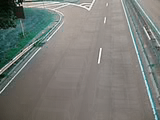

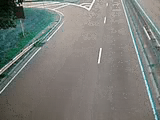

In [ ]:
display_and_save_results(background_avg, background_gmm)

### Outputs

You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

In [128]:
# helper functions

def display_frames(frames, fps=10.0):
    """
    Display the frames as a video.
    """
    eps = 0.0001

    wait_time = int(1000 // fps)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2.imshow("video", frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break

    cv2.destroyAllWindows()


def save_frames(frames, fps=10.0, output_path='./results', file_name='temp'):
    """
    Save the frames as a video.
    """
    eps = 0.0001

    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")

    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        cv2.imshow('frame',frame)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break

        vid_wrt.write(frame)


    vid_wrt.release()
    cv2.destroyAllWindows()

#### Frame Averaging

In [124]:
pip install opencv-python-headless


In [146]:
import imageio

def make_gif(frames, gif_path, fps):
  imageio.mimsave(gif_path, frames, fps=fps)



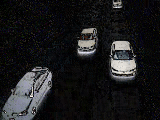

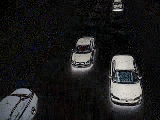

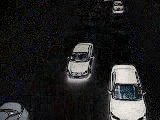

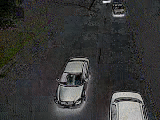

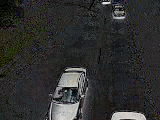

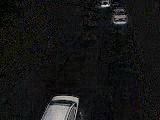

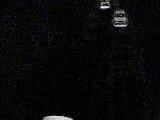

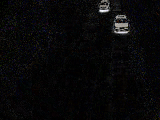

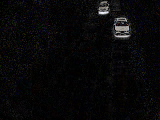

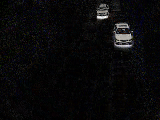

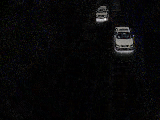

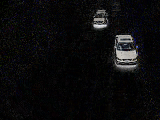

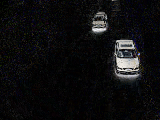

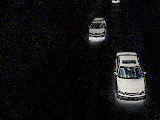

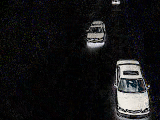

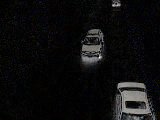

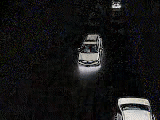

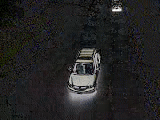

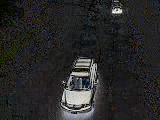

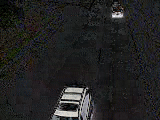

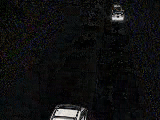

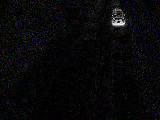

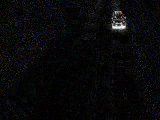

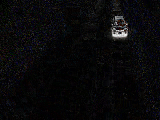

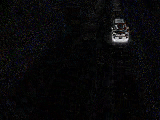

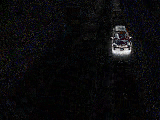

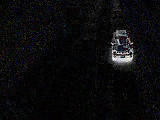

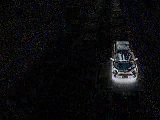

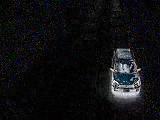

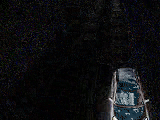

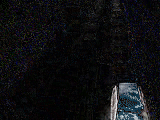

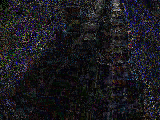

In [156]:
def create_foreground_video(main_frames, background_avg, background_gmm, video_path, fps=10):
    foreground_frames = []
    for frame in main_frames:
        # Subtract background from the main frame
        foreground_avg = np.abs(frame - background_avg)
        foreground_gmm = np.abs(frame - background_gmm)

        foreground_frames.append(foreground_gmm)

    # Create the video using the helper function
    save_frames(foreground_frames, fps=fps, output_path='', file_name=video_path)

    # Create GIF from foreground frames
    gif_path = video_path.replace('.mp4', '.gif')
    foreground_frames = [np.uint8(frame) for frame in foreground_frames]
    make_gif(foreground_frames, gif_path, fps=fps)

# Define the output path and filename for the foreground MP4 video
foreground_video_path = '/content/drive/MyDrive/Result/foreground_gmm.mp4'

# Create the foreground MP4 video using the frames and specified parameters
create_foreground_video(test_frames, background_avg, background_gmm, foreground_video_path, fps=10)


In [154]:
import subprocess
gif_path = foreground_video_path.replace('.mp4', '.gif')
# Construct the ffmpeg command as a list of strings
ffmpeg_command = [
    'ffmpeg',
    '-i', foreground_video_path,
    '-vf', 'fps=10,scale=320:-1:flags=lanczos',
    '-c:v', 'gif',
    '-f', 'gif',  # Explicitly specify the output format as GIF
    gif_path
]

# Execute the ffmpeg command
subprocess.run(ffmpeg_command)



CompletedProcess(args=['ffmpeg', '-i', '/content/drive/MyDrive/Result/foreground.mp4', '-vf', 'fps=10,scale=320:-1:flags=lanczos', '-c:v', 'gif', '-f', 'gif', '/content/drive/MyDrive/Result/foreground.gif'], returncode=0)

#### GMMs per pixel

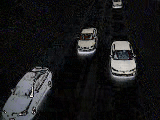

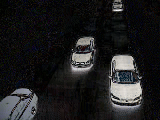

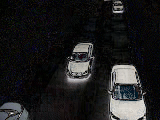

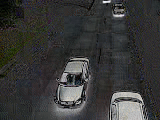

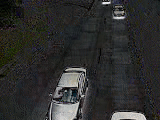

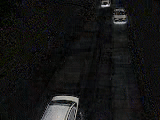

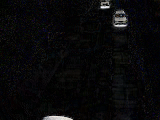

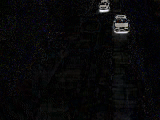

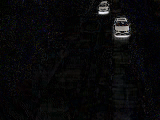

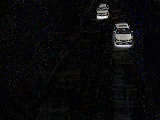

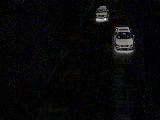

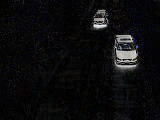

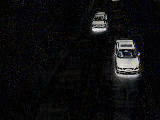

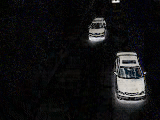

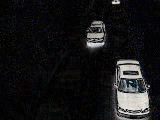

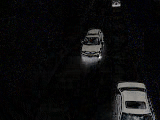

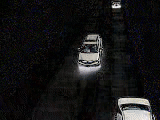

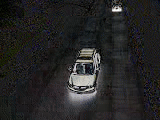

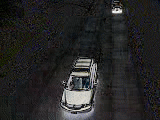

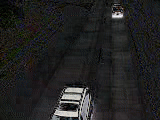

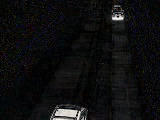

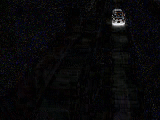

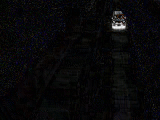

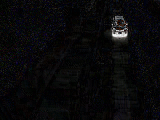

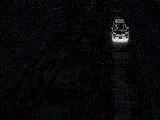

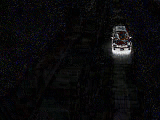

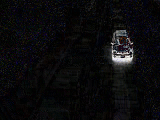

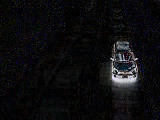

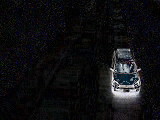

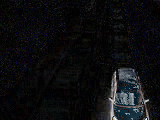

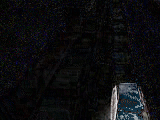

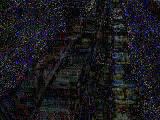

In [155]:
def create_foreground_video(main_frames, background_avg, background_gmm, video_path, fps=10):
    foreground_frames = []
    for frame in main_frames:
        # Subtract background from the main frame
        foreground_avg = np.abs(frame - background_avg)
        foreground_gmm = np.abs(frame - background_gmm)

        foreground_frames.append(foreground_avg)

    # Create the video using the helper function
    save_frames(foreground_frames, fps=fps, output_path='', file_name=video_path)

    # Create GIF from foreground frames
    gif_path = video_path.replace('.mp4', '.gif')
    foreground_frames = [np.uint8(frame) for frame in foreground_frames]
    make_gif(foreground_frames, gif_path, fps=fps)

# Define the output path and filename for the foreground MP4 video
foreground_video_path = '/content/drive/MyDrive/Result/foreground_avg.mp4'

# Create the foreground MP4 video using the frames and specified parameters
create_foreground_video(test_frames, background_avg, background_gmm, foreground_video_path, fps=10)
